In [7]:
%reload_ext autoreload
%autoreload 2

import mlflow
import os
import numpy as np
import pandas as pd
import sys
import seaborn as sns
import xgboost as xgb

from loguru import logger
from matplotlib import pyplot as plt
from pathlib import Path
from pycaret import regression
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor


sys.path.append(str(Path.cwd().parent))
sys.path.append(os.path.join(str(Path.cwd().parent), "src"))
from src.evaluate import evaluate_models
from plot import prediction_error_plot, residual_plot
from settings.params import *
from src.tuning import fine_tune_models

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

In [8]:
data = pd.read_csv(CLEANED_DATA)
TARGET_NAME = MODEL_PARAMS['TARGET_NAME']

In [9]:
mlflow.set_tracking_uri(uri="http://localhost:8080")

# Modeling


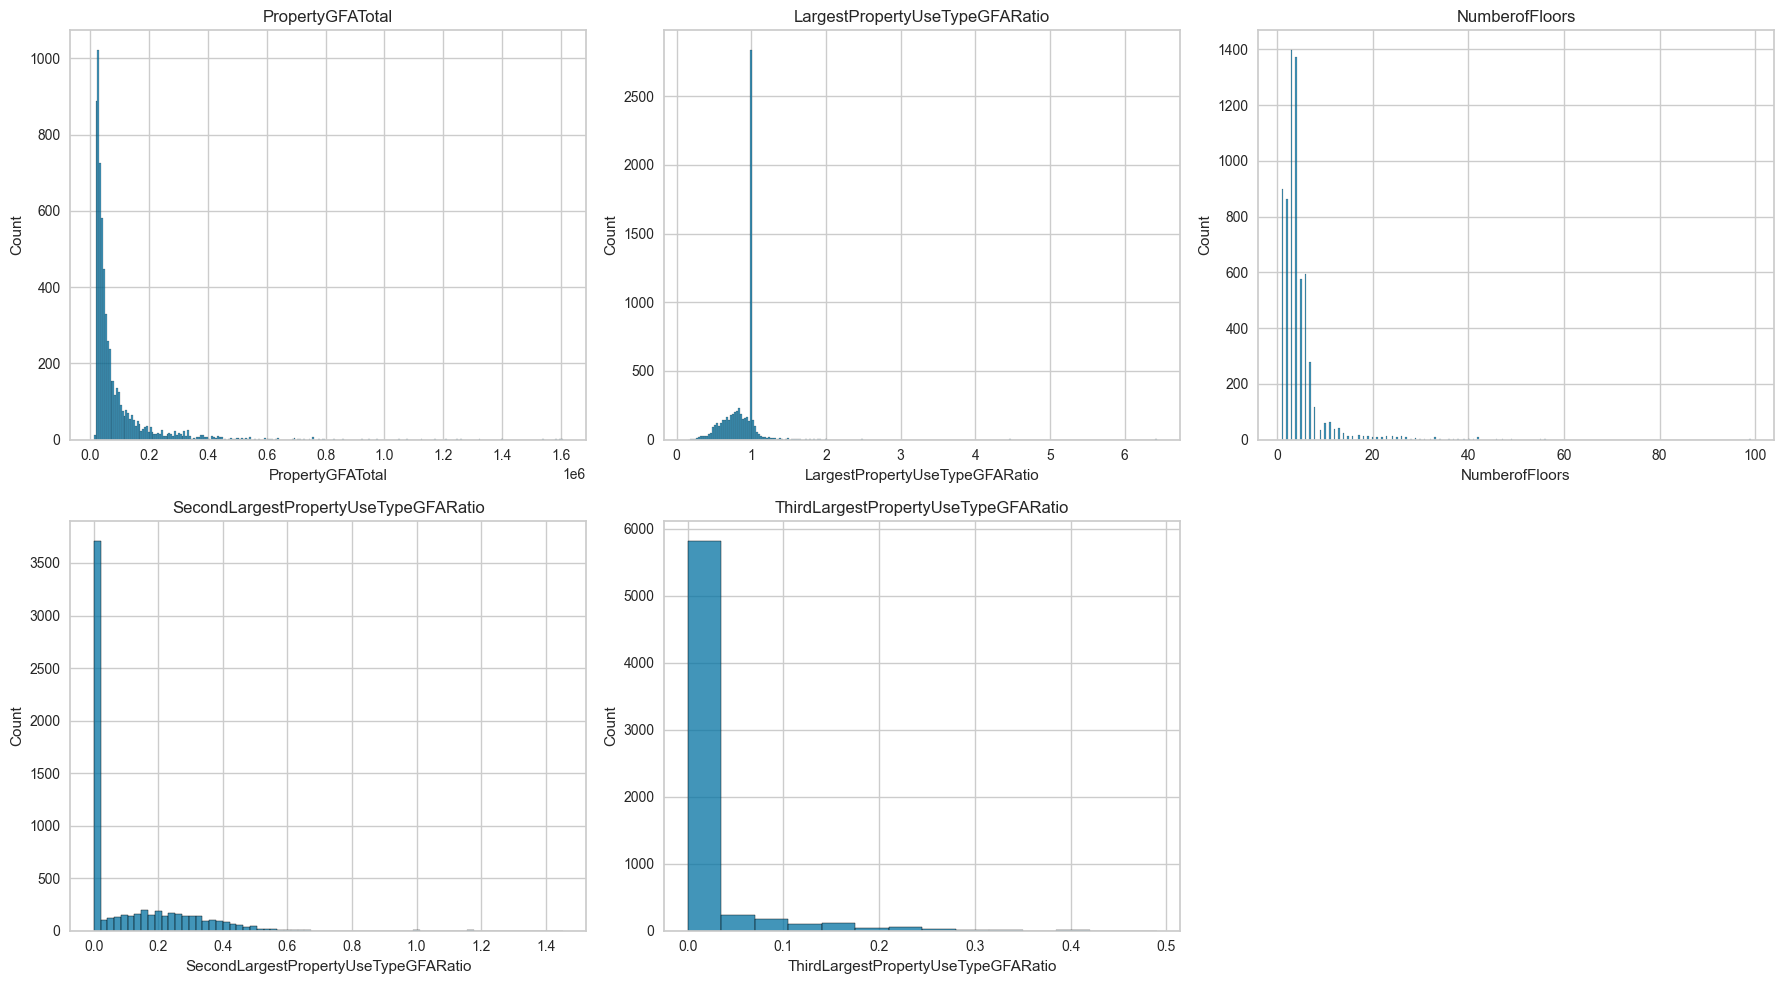

In [12]:
numerical_features = data.drop(TARGET_NAME, axis=1).select_dtypes(include=['float64', 'int64']).columns
numerical_data = data.loc[:, numerical_features]

num_cols = 3
num_rows = (len(numerical_features) + num_cols - 1) // num_cols  # calculate the number of rows needed
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*6, num_rows*5))  # adjust figsize as needed

for i, col in enumerate(numerical_features):
    row = i // num_cols
    col_pos = i % num_cols
    sns.histplot(numerical_data[col], kde=False, ax=axes[row, col_pos])
    axes[row, col_pos].set_title(col)

# Remove unused axes
for i in range(len(numerical_features), len(axes.flat)):
    fig.delaxes(axes.flat[i])

plt.tight_layout()
plt.show()

All five distributions in the image appear to be skewed. We are then going to use log transforms on the numerical features in the preprocessing pipeline for the model in order to decrease the skewness.


## Train/Test Split


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data.drop(TARGET_NAME, axis=1), data[TARGET_NAME], test_size=MODEL_PARAMS["TEST_SIZE"], random_state=SEED)

logger.info(f"\nX train: {x_train.shape}\nY train: {y_train.shape}\n"
            f"X test: {x_test.shape}\nY test: {y_test.shape}")

## Training


In [ ]:
df = x_train.copy()
df[TARGET_NAME] = np.log(y_train)

In [ ]:
exp_reg = regression.setup(df, target=TARGET_NAME, max_encoding_ohe=200, log_experiment=True, experiment_name="building-energy-prediction-training", train_size=0.8)
regression.set_config('seed', SEED)

# Removing useless metrics improve training speed
regression.remove_metric('MAPE')
regression.remove_metric('MSE')
regression.remove_metric('RMSLE')

In [ ]:
best_threes_model = regression.compare_models(n_select=3)

In [ ]:
mlflow.end_run()

Training on multiple types of models with PyCaret shows that for this problem, the models: ExtraTreesRegressor, XGBRegressor, and RandomForestRegressor are the most suitable. However, we believe that the performance obtained during this initial training can be significantly improved. We will wait to do parameter tuning and obtain the final models before making a choice.


## Fine-Tuning


In [ ]:
ESTIMATOR_PARAMS = {
    ExtraTreesRegressor.__name__: {
        "estimator": ExtraTreesRegressor(),
        "params": {
            'regressor__estimator__n_estimators': np.arange(10, 200, 5),
        }
    },
    RandomForestRegressor.__name__: {
        "estimator": RandomForestRegressor(),
        "params": {
            'regressor__estimator__n_estimators': np.arange(10, 200, 5),
        }
    },
    xgb.XGBRegressor.__name__: {
        "estimator": xgb.XGBRegressor(),
        "params": {
            'regressor__estimator__n_estimators': np.arange(10, 200, 5),
        }
    }
}

In [ ]:
search_cvs = fine_tune_models(ESTIMATOR_PARAMS, x_train, y_train)

## Model Evaluation on Test Data


We are going to evaluate the fine-tuned models to see which one we are going to pick as the final model.


In [ ]:
# Obtaining best_models after fine-tuning
models = { f"{estimator_name}": search_cv.best_estimator_ for estimator_name, search_cv in search_cvs.items()}

In [ ]:
# Get best estimator found after evaluation
best_estimator, score = evaluate_models(models, x_train, x_test, y_train, y_test)
logger.info(f"""{best_estimator} is the best estimator found for this problem with an R2 score of {score}""")

After evaluation, we arrive at the conclusion that the best model for this problem is the **Extra Trees Regressor**. Before deploying the model, the best parameters will be picked for the model registry.


### Prediction Error Plot


In [ ]:
prediction_error_plot(models, x_train, x_test, y_train, y_test)

### Residual Plot


In [ ]:
residual_plot(models, x_train, x_test, y_train, y_test)